##Storing the Books and their Structures

In [130]:
import pandas as pd

# Step 1: Initialize bookStructures
bookStructures = pd.DataFrame()

# Step 2: Add books
nietzsche_bge_entry = {
    "title": "Beyond Good and Evil",
    "author": "Friedrich Wilhelm Nietzsche",
    "source_url": "https://www.gutenberg.org/cache/epub/4363/pg4363.txt",
}

bookStructures = pd.concat([
    bookStructures,
    pd.DataFrame([nietzsche_bge_entry])
], ignore_index=True)



In [131]:
bookStructures # Show the newly added entry

,title,author,source_url
0,Beyond Good and Evil,Friedrich Wilhelm Nietzsche,https://www.gutenberg.org/cache/epub/4363/pg43...


## Turning Books into chunks, one chunk per paragraph

In [132]:
import pandas as pd
import requests
import re
from uuid import uuid4

# Step 3: Define helpers
def download_and_clean_text(url):
    response = requests.get(url)
    raw_text = response.text

    start_marker = "PREFACE"
    end_marker = "*** END OF THE PROJECT GUTENBERG"

    start = raw_text.find(start_marker)
    end = raw_text.find(end_marker)

    if start == -1 or end == -1:
        raise ValueError("Start or end marker not found.")

    return raw_text[start:end].strip()

def chunk_paragraphs(text, author, work):
    normalized = text.replace("\r", "").replace("\n", " ")
    paragraphs = re.split(r'\s{2,}', normalized.strip())

    return [
        {
            "id": str(uuid4()),
            "author": author,
            "work": work,
            "chunk_id": i,
            "text": para.strip()
        }
        for i, para in enumerate(paragraphs) if len(para.strip()) >= 100
    ]

# Step 4: Loop over books and generate chunks
all_chunks = []

for _, row in bookStructures.iterrows():
    print(f"Processing: {row['title']} by {row['author']}")
    try:
        text = download_and_clean_text(row['source_url'])
        chunks = chunk_paragraphs(text, row['author'], row['title'])
        all_chunks.extend(chunks)
        print(f"  -> {len(chunks)} chunks created.")
    except Exception as e:
        print(f"  !! Failed to process {row['title']}: {e}")

# Convert to DataFrame
chunk_df = pd.DataFrame(all_chunks)

Processing: Beyond Good and Evil by Friedrich Wilhelm Nietzsche
  -> 253 chunks created.


In [133]:
chunks_df = pd.DataFrame(all_chunks)

# Display the first few rows
chunks_df.head()

,id,author,work,chunk_id,text
0,257259b1-87d8-456b-9bc2-8b0cbd3ff6d8,Friedrich Wilhelm Nietzsche,Beyond Good and Evil,21,SUPPOSING that Truth is a woman--what then? Is...
1,ea17477a-a096-4fe3-9901-37c44c8a4b0d,Friedrich Wilhelm Nietzsche,Beyond Good and Evil,24,"1. The Will to Truth, which is to tempt us to ..."
2,8c711ba4-513c-410d-b535-0f6f19e14741,Friedrich Wilhelm Nietzsche,Beyond Good and Evil,25,"2. ""HOW COULD anything originate out of its op..."
3,0ef86244-e831-46dc-9ca9-d8b476828743,Friedrich Wilhelm Nietzsche,Beyond Good and Evil,26,"3. Having kept a sharp eye on philosophers, an..."
4,68ee49bd-b189-4767-924c-5a2084cbd852,Friedrich Wilhelm Nietzsche,Beyond Good and Evil,27,4. The falseness of an opinion is not for us a...


## Reviewing Chunks

Total number of chunks: 253



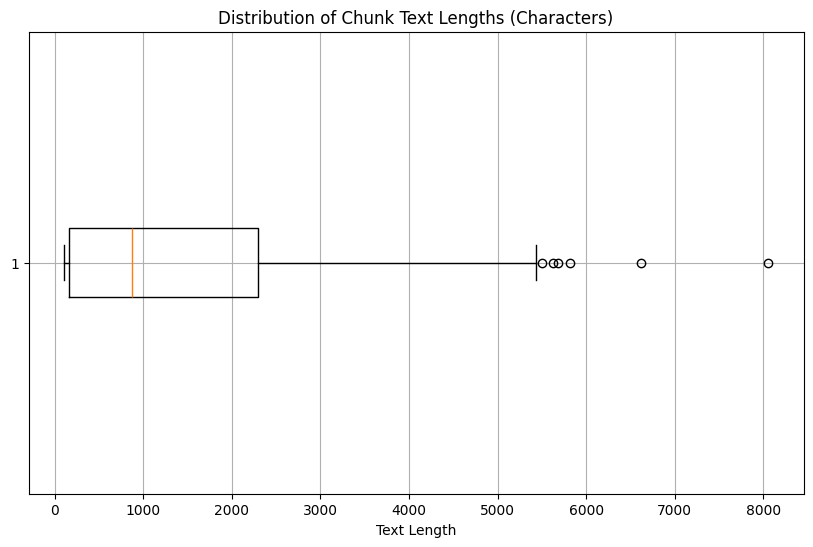

Longest Chunk:

author         Friedrich Wilhelm Nietzsche
work                  Beyond Good and Evil
chunk_id                               316
text_length                           8058
Name: 217, dtype: object

Text:

260. In a tour through the many finer and coarser moralities which have hitherto prevailed or still prevail on the earth, I found certain traits recurring regularly together, and connected with one another, until finally two primary types revealed themselves to me, and a radical distinction was brought to light. There is MASTER-MORALITY and SLAVE-MORALITY,--I would at once add, however, that in all higher and mixed civilizations, there are also attempts at the reconciliation of the two moralities, but one finds still oftener the confusion and mutual misunderstanding of them, indeed sometimes their close juxtaposition--even in the same man, within one soul. The distinctions of moral values have either originated in a ruling caste, pleasantly conscious of being different

In [134]:
import pandas as pd
import matplotlib.pyplot as plt

# Add text length column
chunks_df['text_length'] = chunks_df['text'].apply(len)
print(f"Total number of chunks: {len(chunks_df)}\n")


# Box and whisker plot
plt.figure(figsize=(10, 6))
plt.boxplot(chunks_df['text_length'], vert=False)
plt.title('Distribution of Chunk Text Lengths (Characters)')
plt.xlabel('Text Length')
plt.grid(True)
plt.show()

# Display longest chunk
longest_chunk = chunks_df.loc[chunks_df['text_length'].idxmax()]
print("Longest Chunk:\n")
print(longest_chunk[['author', 'work', 'chunk_id', 'text_length']])
print("\nText:\n")
print(longest_chunk['text'])


## Creatig  Open AI Text Embeedings for each Chunk

In [114]:
import openai
from openai import OpenAI

client = OpenAI(api_key="YOUR-KEY")  # Replace with your real key


In [136]:
## Create the embeddings for each of the chunks
import time

def embed_texts(texts, model="text-embedding-3-small"):
    response = client.embeddings.create(
        input=texts,
        model=model
    )
    return [item.embedding for item in response.data]
# Add empty column
chunks_df['embedding'] = None

# Process in batches
batch_size = 100

for i in range(0, len(chunks_df), batch_size):
    batch_texts = chunks_df.iloc[i:i+batch_size]['text'].tolist()

    try:
        batch_embeddings = embed_texts(batch_texts)
        for j, embedding in enumerate(batch_embeddings):
            chunks_df.at[i + j, 'embedding'] = embedding  # ✅ set one row at a time
    except Exception as e:
        print(f"Failed on batch {i}-{i+batch_size}: {e}")
        time.sleep(5)

In [115]:
#Query embedding
def embed_query(query, model="text-embedding-3-small"):
    response = client.embeddings.create(
        input=[query],
        model=model
    )
    return response.data[0].embedding


In [117]:
#Compare the embedding similarities
import numpy as np
def cosine_similarity(vec1, vec2):
    v1 = np.array(vec1)
    v2 = np.array(vec2)
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))


In [139]:
def get_top_chunks(query, df, top_k=5):
    query_vec = embed_query(query)

    similarities = []
    for idx, row in df.iterrows():
        if isinstance(row['embedding'], list):
            score = cosine_similarity(query_vec, row['embedding'])
            similarities.append((score, row))

    # Sort by similarity
    top = sorted(similarities, key=lambda x: x[0], reverse=True)[:top_k]
    return top  # now returns list of (score, row)


In [141]:
## Displaying results
import textwrap

def display_chunks(scored_chunks, width=100):
    for i, (score, row) in enumerate(scored_chunks):
        print(f"\n=== Result #{i+1} ===")
        print(f"Similarity Score: {score:.4f}")
        print(f"Author: {row['author']}")
        print(f"Work: {row['work']}")
        print(f"Chunk ID: {row['chunk_id']}")
        print("-" * width)
        print(textwrap.fill(row['text'], width=width))
        print("-" * width)


##Using

In [143]:
query = "Nietzsche discussing the morality of winning"
top_chunks = get_top_chunks(query, chunks_df, top_k=5)
display_chunks(top_chunks)


=== Result #1 ===
Similarity Score: 0.4944
Author: Friedrich Wilhelm Nietzsche
Work: Beyond Good and Evil
Chunk ID: 257
----------------------------------------------------------------------------------------------------
221. "It sometimes happens," said a moralistic pedant and trifle-retailer, "that I honour and
respect an unselfish man: not, however, because he is unselfish, but because I think he has a right
to be useful to another man at his own expense. In short, the question is always who HE is, and who
THE OTHER is. For instance, in a person created and destined for command, self-denial and modest
retirement, instead of being virtues, would be the waste of virtues: so it seems to me. Every system
of unegoistic morality which takes itself unconditionally and appeals to every one, not only sins
against good taste, but is also an incentive to sins of omission, an ADDITIONAL seduction under the
mask of philanthropy--and precisely a seduction and injury to the higher, rarer, and mor